## 📌 K-Nearest Neighbors (KNN)

**KNN** is a **supervised learning algorithm** mainly used for **classification** (sometimes regression).  
It is a **lazy learner** since it stores training data and makes predictions only when needed.

---

### 🔹 How it Works
1. Choose a value of **k** (number of neighbors).  
2. Compute distance (commonly Euclidean):  
   $$
   d(X, Y) = \sqrt{\sum_{i=1}^{n}(X_i - Y_i)^2}
   $$
3. Find the **k nearest neighbors**.  
4. Prediction:  
   - **Classification** → majority vote.  
   - **Regression** → average value.  

---

### 🔹 Choosing k
- Small **k** → sensitive to noise (overfitting).  
- Large **k** → oversmooths, may miss patterns (underfitting).  
- Methods: **Cross-validation**, **Elbow method**, use **odd k** to avoid ties.  

---

### 🔹 Distance Metrics
- **Euclidean**: straight-line distance.  
- **Manhattan**: grid-like (taxicab).  
- **Minkowski**: general form (p=1 → Manhattan, p=2 → Euclidean).  

---

### 🔹 Pros
- Simple, no training phase.  
- Works for classification & regression.  
- Few parameters (k + distance metric).  

### 🔹 Cons
- Slow with large data (needs all comparisons).  
- Struggles with high-dimensional data.  
- Sensitive to noisy data/outliers.  

---

In [89]:
%matplotlib inline
import pickle
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable

from pandas import set_option
set_option("display.max_rows", 10)
pd.options.mode.chained_assignment = None

In [49]:
train_set_df=pickle.load(open('../../data/train_set_df.pickled','rb'))
test_set_df=pickle.load(open('../../data/test_set_df.pickled','rb'))


In [50]:
train_set_df.shape, test_set_df.shape

((3737, 16), (412, 16))

In [51]:
print("train data\n",train_set_df.head())

test_set_df.head()

train data
    Facies Formation  Well Name   Depth     GR  ILD_log10  DeltaPHI   PHIND  \
0       3     A1 SH  SHRIMPLIN  2793.0  77.45      0.664       9.9  11.915   
1       3     A1 SH  SHRIMPLIN  2793.5  78.26      0.661      14.2  12.565   
2       3     A1 SH  SHRIMPLIN  2794.0  79.05      0.658      14.8  13.050   
3       3     A1 SH  SHRIMPLIN  2794.5  86.10      0.655      13.9  13.115   
4       3     A1 SH  SHRIMPLIN  2795.0  74.58      0.647      13.5  13.300   

    PE  NM_M  RELPOS   PHID    NPHI       VSH  Bulk Density PE_filled  
0  4.6     1   1.000  6.965  16.865  0.191740      2.453403  Original  
1  4.1     1   0.979  5.465  19.665  0.194048      2.442677  Original  
2  3.6     1   0.957  5.650  20.450  0.196299      2.434675  Original  
3  3.5     1   0.936  6.165  20.065  0.216384      2.433603  Original  
4  3.4     1   0.915  6.550  20.050  0.183564      2.430550  Original  


,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,PHID,NPHI,VSH,Bulk Density,PE_filled
1071,1,B1 SH,SHANKLE,2842.0,52.720,0.590000,2.2,9.88,3.200,1,0.367,8.78,10.98,0.121285,2.486980,Original
2594,1,B4 SH,CROSS H CATTLE,2729.0,54.345,0.160168,1.4,16.20,2.975,1,0.732,15.50,16.90,0.125914,2.382700,Original
2600,1,B4 SH,CROSS H CATTLE,2732.0,61.969,0.157457,4.2,17.80,2.863,1,0.625,15.70,19.90,0.147635,2.356300,Original
2629,1,B4 SH,CROSS H CATTLE,2746.5,79.285,0.313234,5.1,14.75,2.849,1,0.107,12.20,17.30,0.196968,2.406625,Original
2551,1,B3 SH,CROSS H CATTLE,2708.0,68.186,0.519040,2.0,11.80,3.162,1,0.540,10.80,12.80,0.165347,2.455300,Original


In [52]:
train_set_df["Well Name"].value_counts()

Well Name
CROSS H CATTLE     448
SHRIMPLIN          440
ALEXANDER D        432
NEWBY              415
LUKE G U           408
SHANKLE            407
KIMZEY A           395
NOLAN              363
CHURCHMAN BIBLE    355
Recruit F9          74
Name: count, dtype: int64

In [53]:
test_set_df["Well Name"].value_counts()

Well Name
CROSS H CATTLE     53
LUKE G U           53
NOLAN              52
CHURCHMAN BIBLE    49
NEWBY              48
KIMZEY A           44
SHANKLE            42
ALEXANDER D        34
SHRIMPLIN          31
Recruit F9          6
Name: count, dtype: int64

In [54]:
blind=test_set_df
training_data=train_set_df

In [55]:
training_data['Well Name'] = training_data['Well Name'].astype('category')
training_data['Formation'] = training_data['Formation'].astype('category')
training_data['Well Name'].unique()

['SHRIMPLIN', 'ALEXANDER D', 'SHANKLE', 'LUKE G U', 'KIMZEY A', 'CROSS H CATTLE', 'NOLAN', 'Recruit F9', 'NEWBY', 'CHURCHMAN BIBLE']
Categories (10, object): ['ALEXANDER D', 'CHURCHMAN BIBLE', 'CROSS H CATTLE', 'KIMZEY A', ..., 'NOLAN', 'Recruit F9', 'SHANKLE', 'SHRIMPLIN']

### Before we plot the well data, let's define a color map so the facies are represented by consistent color in all the plots in this tutorial.

In [56]:
# 1=sandstone  2=c_siltstone   3=f_siltstone # 4=marine_silt_shale 
#5=mudstone 6=wackestone 7=dolomite 8=packstone 9=bafflestone
facies_colors = ['#F4D03F', '#F5B041', '#DC7633','#A569BD',
       '#000000', '#000080', '#2E86C1', '#AED6F1', '#196F3D']

facies_labels = ['SS', 'CSiS', 'FSiS', 'SiSh', 'MS',
                 'WS', 'D','PS', 'BS']
#facies_color_map is a dictionary that maps facies labels
#to their respective colors
facies_color_map = {}
for ind, label in enumerate(facies_labels):
    facies_color_map[label] = facies_colors[ind]

def label_facies(row, labels):
    return labels[ row['Facies'] -1]
    
training_data.loc[:,'FaciesLabels'] = training_data.apply(lambda row: label_facies(row, facies_labels), axis=1)
training_data.describe()

,Facies,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,PHID,NPHI,VSH,Bulk Density
count,3737.000000,3737.000000,3737.000000,3737.000000,3737.000000,3737.000000,3737.000000,3737.000000,3737.000000,3737.000000,3737.000000,3737.000000,3737.000000
mean,4.503880,2907.308804,64.865990,0.658833,4.468016,13.215483,3.766517,1.519133,0.522110,10.981475,15.449491,0.155888,2.431945
std,2.474938,132.900638,30.174506,0.252715,5.252294,7.091140,0.849495,0.499701,0.285763,7.988407,7.109653,0.085967,0.117004
min,1.000000,2574.500000,10.149000,-0.025949,-21.832000,0.550000,0.200000,1.000000,0.000000,-5.000000,2.090000,0.000000,1.257400
25%,2.000000,2822.500000,44.710000,0.495000,1.667000,8.540000,3.200000,1.000000,0.278000,6.255000,10.100000,0.098464,2.385026
50%,4.000000,2933.000000,65.001000,0.639000,4.300000,12.050000,3.600000,2.000000,0.528000,8.944500,14.880000,0.156273,2.451175
75%,6.000000,3007.000000,79.340000,0.821000,7.562000,16.059000,4.300000,2.000000,0.767000,13.164000,19.400000,0.197125,2.509090
max,9.000000,3138.000000,361.150000,1.800000,19.312000,84.400000,8.094000,2.000000,1.000000,83.500000,85.400000,1.000000,2.640925


In [58]:
training_data.describe()

,Facies,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,PHID,NPHI,VSH,Bulk Density
count,3737.000000,3737.000000,3737.000000,3737.000000,3737.000000,3737.000000,3737.000000,3737.000000,3737.000000,3737.000000,3737.000000,3737.000000,3737.000000
mean,4.503880,2907.308804,64.865990,0.658833,4.468016,13.215483,3.766517,1.519133,0.522110,10.981475,15.449491,0.155888,2.431945
std,2.474938,132.900638,30.174506,0.252715,5.252294,7.091140,0.849495,0.499701,0.285763,7.988407,7.109653,0.085967,0.117004
min,1.000000,2574.500000,10.149000,-0.025949,-21.832000,0.550000,0.200000,1.000000,0.000000,-5.000000,2.090000,0.000000,1.257400
25%,2.000000,2822.500000,44.710000,0.495000,1.667000,8.540000,3.200000,1.000000,0.278000,6.255000,10.100000,0.098464,2.385026
50%,4.000000,2933.000000,65.001000,0.639000,4.300000,12.050000,3.600000,2.000000,0.528000,8.944500,14.880000,0.156273,2.451175
75%,6.000000,3007.000000,79.340000,0.821000,7.562000,16.059000,4.300000,2.000000,0.767000,13.164000,19.400000,0.197125,2.509090
max,9.000000,3138.000000,361.150000,1.800000,19.312000,84.400000,8.094000,2.000000,1.000000,83.500000,85.400000,1.000000,2.640925


In [73]:
def make_facies_log_plot(logs, facies_colors,save_path='../../figures/supervised/Well_log_plot.png'):
    """
    Plot well logs with facies classification.

    Parameters
    ----------
    logs : DataFrame
        Must contain columns: ['Depth','GR','ILD_log10','DeltaPHI','PHIND','PE','Facies','Well Name']
    facies_colors : list
        List of facies colors (len = number of facies)
    save_path : str or None
        If given, saves the plot to this file path
    """
    
    logs = logs.sort_values(by='Depth')
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    
    cluster=np.repeat(np.expand_dims(logs['Facies'].values,1), 100, 1)
    
    f, ax = plt.subplots(nrows=1, ncols=6, figsize=(8, 12))
    ax[0].plot(logs.GR, logs.Depth, '-g')
    ax[1].plot(logs.ILD_log10, logs.Depth, '-')
    ax[2].plot(logs.DeltaPHI, logs.Depth, '-', color='0.5')
    ax[3].plot(logs.PHIND, logs.Depth, '-', color='r')
    ax[4].plot(logs.PE, logs.Depth, '-', color='black')
    im=ax[5].imshow(cluster, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    
    divider = make_axes_locatable(ax[5])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im, cax=cax)
    cbar.set_label((17*' ').join([' SS ', 'CSiS', 'FSiS', 
                                'SiSh', ' MS ', ' WS ', ' D  ', 
                                ' PS ', ' BS ']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-1):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_xlabel("GR")
    ax[0].set_xlim(logs.GR.min(),logs.GR.max())
    ax[1].set_xlabel("ILD_log10")
    ax[1].set_xlim(logs.ILD_log10.min(),logs.ILD_log10.max())
    ax[2].set_xlabel("DeltaPHI")
    ax[2].set_xlim(logs.DeltaPHI.min(),logs.DeltaPHI.max())
    ax[3].set_xlabel("PHIND")
    ax[3].set_xlim(logs.PHIND.min(),logs.PHIND.max())
    ax[4].set_xlabel("PE")
    ax[4].set_xlim(logs.PE.min(),logs.PE.max())
    ax[5].set_xlabel('Facies')
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([])
    ax[5].set_xticklabels([])

    # Ttle saving the figure
    well_name=logs.iloc[0]['Well Name']
    formation=logs.iloc[0]['Formation']
    plt.suptitle('Well: %s, Formation: %s'%(well_name,formation), fontsize=14,y=0.94)
    f.suptitle(f'Well: {well_name}', fontsize=14, y=0.94)
    # Save the figure
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
        print(f"✅ Plot saved to {save_path}")
    plt.show()
    return save_path

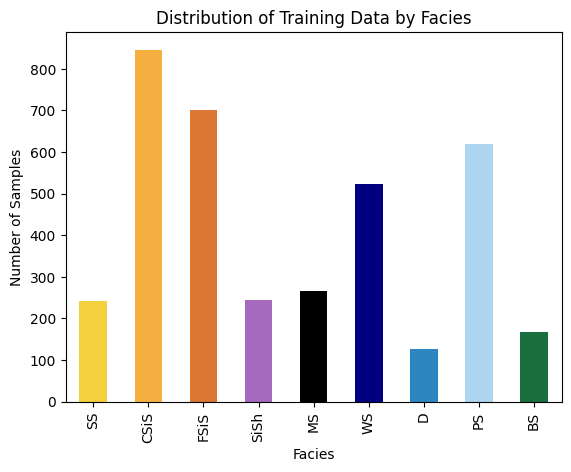

In [63]:
#count the number of unique entries for each facies, sort them by
#facies number (instead of by number of entries)


facies_counts = training_data['Facies'].value_counts().sort_index()
#use facies labels to index each count
facies_counts.index = facies_labels

#light_rgb = colors.ListedColormap(facies_colors)
facies_counts.plot(kind='bar',color=facies_colors, 
                   
                   title='Distribution of Training Data by Facies')

plt.xlabel('Facies'); plt.ylabel('Number of Samples');
plt.savefig('../../figures/supervised/knn_Distribution of Training Data by Facies.png', dpi=300, bbox_inches='tight')

### Conditioning the data set

#### Extract the features for train the dataset for the facies classification

In [69]:
correct_facies_labels = training_data['FaciesLabels'].values

feature_vectors = training_data.drop(['Formation', 'Well Name', 'Depth','Facies','FaciesLabels'], axis=1)

feature_vectors.describe()

,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,PHID,NPHI,VSH,Bulk Density
count,3737.000000,3737.000000,3737.000000,3737.000000,3737.000000,3737.000000,3737.000000,3737.000000,3737.000000,3737.000000,3737.000000
mean,64.865990,0.658833,4.468016,13.215483,3.766517,1.519133,0.522110,10.981475,15.449491,0.155888,2.431945
std,30.174506,0.252715,5.252294,7.091140,0.849495,0.499701,0.285763,7.988407,7.109653,0.085967,0.117004
min,10.149000,-0.025949,-21.832000,0.550000,0.200000,1.000000,0.000000,-5.000000,2.090000,0.000000,1.257400
25%,44.710000,0.495000,1.667000,8.540000,3.200000,1.000000,0.278000,6.255000,10.100000,0.098464,2.385026
50%,65.001000,0.639000,4.300000,12.050000,3.600000,2.000000,0.528000,8.944500,14.880000,0.156273,2.451175
75%,79.340000,0.821000,7.562000,16.059000,4.300000,2.000000,0.767000,13.164000,19.400000,0.197125,2.509090
max,361.150000,1.800000,19.312000,84.400000,8.094000,2.000000,1.000000,83.500000,85.400000,1.000000,2.640925


In [ ]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(feature_vectors)
scaled_features = scaler.transform(feature_vectors)



In [78]:
from sklearn.preprocessing import StandardScaler

# Select only numeric columns
numeric_features = feature_vectors.select_dtypes(include=['int64', 'float64'])

# Fit and transform
scaler = StandardScaler().fit(numeric_features)
scaled_features = scaler.transform(numeric_features)

# Put back into DataFrame (with original column names)
scaled_df = pd.DataFrame(scaled_features, columns=numeric_features.columns, index=feature_vectors.index)
scaled_df.head()

,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,PHID,NPHI,VSH,Bulk Density
0,0.417097,0.020449,1.034350,-0.183420,0.981283,-1.039027,1.672552,-0.502855,0.199123,0.417097,0.183420
1,0.443944,0.008576,1.853149,-0.091744,0.392619,-1.039027,1.599055,-0.690652,0.593007,0.443944,0.091744
2,0.470129,-0.003296,1.967400,-0.023340,-0.196045,-1.039027,1.522058,-0.667491,0.703435,0.470129,0.023340
3,0.703801,-0.015169,1.796024,-0.014172,-0.313778,-1.039027,1.448560,-0.603014,0.649276,0.703801,0.014172
4,0.321971,-0.046829,1.719856,0.011920,-0.431510,-1.039027,1.375063,-0.554812,0.647166,0.321971,-0.011920


In [80]:
#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
        scaled_features, correct_facies_labels, test_size=0.3, random_state=42)


### Training the KNN Classifiers

In [79]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5,weights="distance")

In [81]:
knn.fit(X_train, y_train)

,n_neighbors,5
,weights,'distance'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [82]:
predicted_facies = knn.predict(X_test)

from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y_test, predicted_facies))

from sklearn.metrics import classification_report
print(classification_report(y_test, predicted_facies, target_names=facies_labels))      


Accuracy: 0.713903743315508
              precision    recall  f1-score   support

          SS       0.70      0.95      0.81        42
        CSiS       0.75      0.79      0.77       252
        FSiS       0.83      0.56      0.67        45
        SiSh       0.75      0.72      0.73       203
          MS       0.49      0.44      0.46        75
          WS       0.73      0.75      0.74       190
           D       0.82      0.68      0.74        75
          PS       0.67      0.78      0.72        80
          BS       0.67      0.63      0.65       160

    accuracy                           0.71      1122
   macro avg       0.71      0.70      0.70      1122
weighted avg       0.72      0.71      0.71      1122



In [88]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, predicted_facies)
print(conf_mat)

[[ 40   0   0   0   0   2   0   0   0]
 [  0 199   0  42   0   3   8   0   0]
 [  1   0  25   0   4   8   0   4   3]
 [  0  48   0 147   2   3   3   0   0]
 [  0   1   1   1  33  11   0  12  16]
 [ 13   0   1   2   6 143   0   6  19]
 [  0  19   0   4   1   0  51   0   0]
 [  0   0   2   0   2   2   0  62  12]
 [  3   0   1   1  20  25   0   9 101]]


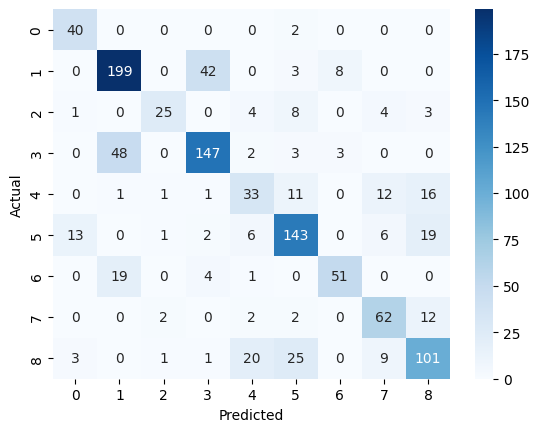

In [94]:
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


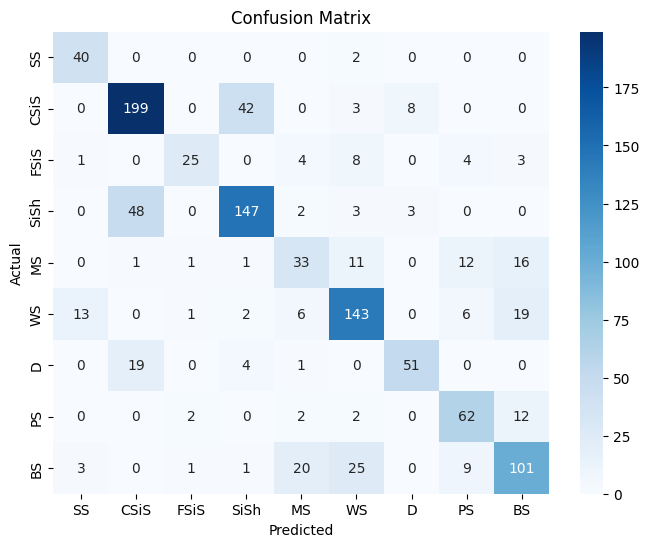

Classification Report:

              precision    recall  f1-score   support

          SS       0.70      0.95      0.81        42
        CSiS       0.75      0.79      0.77       252
        FSiS       0.83      0.56      0.67        45
        SiSh       0.75      0.72      0.73       203
          MS       0.49      0.44      0.46        75
          WS       0.73      0.75      0.74       190
           D       0.82      0.68      0.74        75
          PS       0.67      0.78      0.72        80
          BS       0.67      0.63      0.65       160

    accuracy                           0.71      1122
   macro avg       0.71      0.70      0.70      1122
weighted avg       0.72      0.71      0.71      1122



In [103]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd

# Compute confusion matrix
conf_mat = confusion_matrix(y_test, predicted_facies)

# Convert to DataFrame for better labeling
conf_df = pd.DataFrame(conf_mat, index=facies_labels, columns=facies_labels)

# Plot confusion matrix with Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_df, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.savefig('../../figures/supervised/knn_Confusion Matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Optional: Print F1-score, precision, recall for each facies
report = classification_report(y_test, predicted_facies, target_names=facies_labels)
print("Classification Report:\n")
print(report)
